# label Reclustering Module

## Imports

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans

#Load data set
df = pd.read_csv('D:\\NLP\\Frame_NLP\\archive\\Sent_Cluster\\labeled_clusters48(2).csv')
df.rename(columns = {'category':'Name', 'label':'category'}, inplace = True)
text1 = df[['Name','category']]
text1.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Name,category
0,rises_37_coronavirus_death,coronavirus_coronavirus_case
1,refuses_offer_coronavirus_conspiracy,coronavirus_coronavirus_case
2,expands_change_airport_coronavirus,coronavirus_coronavirus_travel
3,preparing_cut_coronavirus_game,coronavirus_coronavirus_player
4,coronavirus_exercise_case_week,reports_case_coronavirus


## Data Cleaning

In [38]:
#Remove stopwords, punctuation and numbers
column_to_remove = ['Name']
df[column_to_remove]

,Name
0,rises_37_coronavirus_death
1,refuses_offer_coronavirus_conspiracy
2,expands_change_airport_coronavirus
3,preparing_cut_coronavirus_game
4,coronavirus_exercise_case_week
...,...
8371,debunked_number_coronavirus_testimony
8372,invest_portfolio_coronavirus_investing
8373,announces_death_coronavirus_total
8374,coronavirus_run_pace


In [42]:
text2 = text1[column_to_remove].replace({'_':' '}, regex=True)
text2[:10]

,Name
0,rises 37 coronavirus death
1,refuses offer coronavirus conspiracy
2,expands change airport coronavirus
3,preparing cut coronavirus game
4,coronavirus exercise case week
5,coronavirus case emergency
6,rises employee coronavirus number
7,declares emergency coronavirus
8,extends lockdown coronavirus
9,declares curfew coronavirus lockdown


In [25]:
df

,Processed_Title,label_st1,category,Name
0,"US coronavirus death toll rises to 14, most ca...",34,coronavirus_coronavirus_case,rises_37_coronavirus_death
1,"Iran rejects U.S. offer for coronavirus aid, c...",-1,coronavirus_coronavirus_case,refuses_offer_coronavirus_conspiracy
2,TSA is making 3 changes to stop coronavirus fr...,43,coronavirus_coronavirus_travel,expands_change_airport_coronavirus
3,NBA Players to Take Pay Cut Amidst Coronavirus...,6,coronavirus_coronavirus_player,preparing_cut_coronavirus_game
4,"Coronavirus Cases confirmed in North Korea, sa...",11,reports_case_coronavirus,coronavirus_exercise_case_week
...,...,...,...,...
8371,Watch live: Fauci testifies before House panel...,42,signs_package_coronavirus_stimulus,debunked_number_coronavirus_testimony
8372,Ride Out the Coronavirus Mayhem With These ETF...,27,coronavirus_impact_stock,invest_portfolio_coronavirus_investing
8373,Indiana announces 1 more coronavirus death for...,34,coronavirus_coronavirus_case,announces_death_coronavirus_total
8374,Manufacturing: Coronavirus Effect Is Rising,27,coronavirus_impact_stock,coronavirus_run_pace


## Vectorizing Labels

In [90]:
#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(text2)

In [18]:
#TF-IDF (n-gram level)
vectorizer_ntf = TfidfVectorizer(analyzer='word',ngram_range=(1,2))
X_ntf = vectorizer_ntf.fit_transform(text2)

In [19]:
#show matrix
matrix = pd.concat([text2,pd.DataFrame(X_ntf.toarray(),columns=vectorizer_ntf.get_feature_names())],axis=1)

In [20]:
matrix.shape

(8376, 3573)

In [11]:
matrix[['Name','coronavirus','lockdown']]

,Name,coronavirus,lockdown
0,rises 37 coronavirus death,0.067178,0.0
1,refuses offer coronavirus conspiracy,0.057254,0.0
2,expands change airport coronavirus,0.057639,0.0
3,preparing cut coronavirus game,0.054293,0.0
4,coronavirus exercise case week,0.061271,0.0
...,...,...,...
8371,debunked number coronavirus testimony,0.054624,0.0
8372,invest portfolio coronavirus investing,0.054912,0.0
8373,announces death coronavirus total,0.064519,0.0
8374,coronavirus run pace,0.067203,0.0


In [75]:
#TF-IDF (word level)
vectorizer_wtf = TfidfVectorizer(analyzer='word')
X_wtf = vectorizer_wtf.fit_transform(text2)

In [76]:
from tqdm.notebook import tqdm

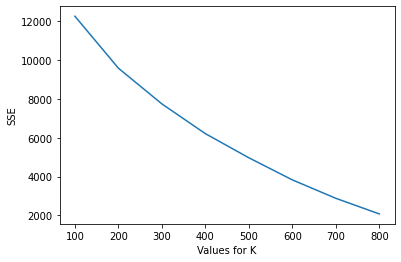

In [77]:
#Test increments of 100 clusters using elbow method
sse={}
for k in np.arange(100,900,100):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_cv)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();

In [21]:
#Create 200 clusters
kmeans = KMeans(n_clusters=200)
kmeans.fit(X_ntf)
result = pd.concat([text1,pd.DataFrame(X_ntf.toarray(),columns=vectorizer_ntf.get_feature_names())],axis=1)
result['cluster'] = kmeans.predict(X_ntf)

C:\Users\hp\miniconda3\envs\SBERT_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
#Label each cluster with the word(s) that all of its food names have in common
clusters = result['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='Name' and x!='cluster' and len(x.split()) == 1])
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')

In [23]:
result_labelled.head()

,Name,000,000 case,000 coronavirus,000 death,000 pandemic,10,10 000,100,100 000,...,year government,year student,year virus,yell,yell teen,youngster,yuan,yuan coronavirus,zoo,label
0,rises_37_coronavirus_death,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rises
1,refuses_offer_coronavirus_conspiracy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coronavirus
2,expands_change_airport_coronavirus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,airport coronavirus
3,preparing_cut_coronavirus_game,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,coronavirus_exercise_case_week,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coronavirus week


In [120]:
result_labelled = 

In [26]:
result_labelled

,Name,000,000 case,000 coronavirus,000 death,000 pandemic,10,10 000,100,100 000,...,year government,year student,year virus,yell,yell teen,youngster,yuan,yuan coronavirus,zoo,label
0,rises_37_coronavirus_death,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rises
1,refuses_offer_coronavirus_conspiracy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coronavirus
2,expands_change_airport_coronavirus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,airport coronavirus
3,preparing_cut_coronavirus_game,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,coronavirus_exercise_case_week,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coronavirus week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8371,debunked_number_coronavirus_testimony,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coronavirus number
8372,invest_portfolio_coronavirus_investing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coronavirus invest investing portfolio
8373,announces_death_coronavirus_total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
8374,coronavirus_run_pace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,


In [24]:
#Visualise sizes of supermarket categories (manually added to result_labelled) and clean clusters
result_summary = pd.pivot_table(result_labelled,index=['label','category'],values=['Name'],aggfunc='count').reset_index().rename(columns={'Name':'count'})
result_treemap = result_summary[(result_summary['label'] != '') & (result_summary['count'] > 1)]
fig = px.treemap(result_treemap,path=['category','label'],values='count')
fig.show();

KeyError: 'category'